<a href="https://colab.research.google.com/github/RishJosh/Sem-I/blob/main/24566027_RishabhJoshi_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing Requisite Libraries

In [31]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow
import scipy.stats as stats

2. Loading Dataset to Dataframe

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
#enter path to csv file in Google drive
df=pd.read_csv('/content/drive/MyDrive/Machine Learning/Assignment/tips (data for regression problem).csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3. Check initial data information

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [15]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [14]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


# 4. Data Preprocessing

In [4]:
# Check for missing values
df.isnull().sum()

# Handle missing values (if any), e.g., drop or impute
df.dropna(inplace=True)

# Encode categorical variables if necessary (e.g., Gender, Day of the Week)
df2 = pd.get_dummies(df, drop_first=True)

# Split the data into features and target variable
X = df2.drop('tip', axis=1)
y = df2['tip']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#5. Analyze Linear Relationships

(a) Scatter Plot

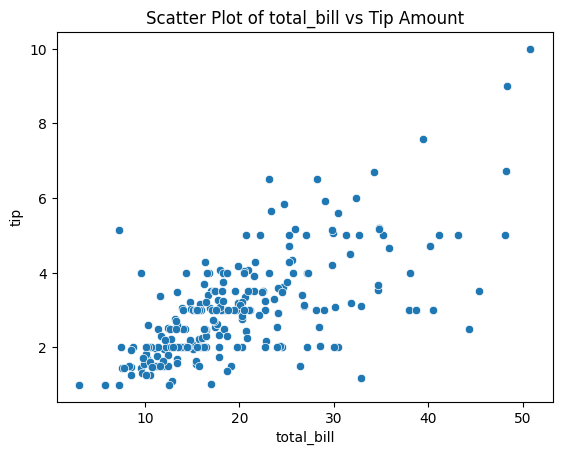

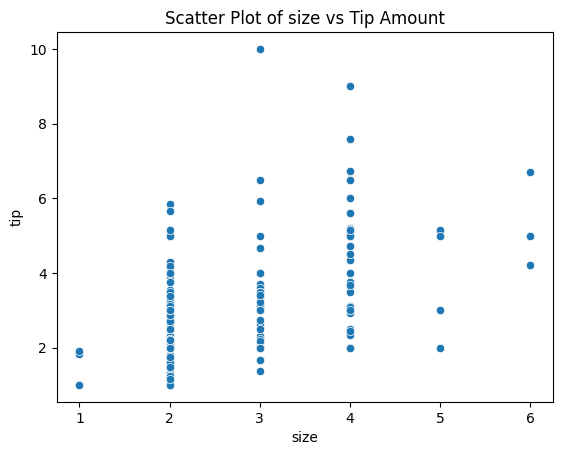

In [36]:
# Scatter plots for each feature against tip_amount
for column in X.columns:
    if column == 'total_bill' or column == 'size':
        plt.figure()
        sns.scatterplot(x=X[column], y=y)
        plt.title(f'Scatter Plot of {column} vs Tip Amount')
        plt.show()

(b) Pair plot for multiple features


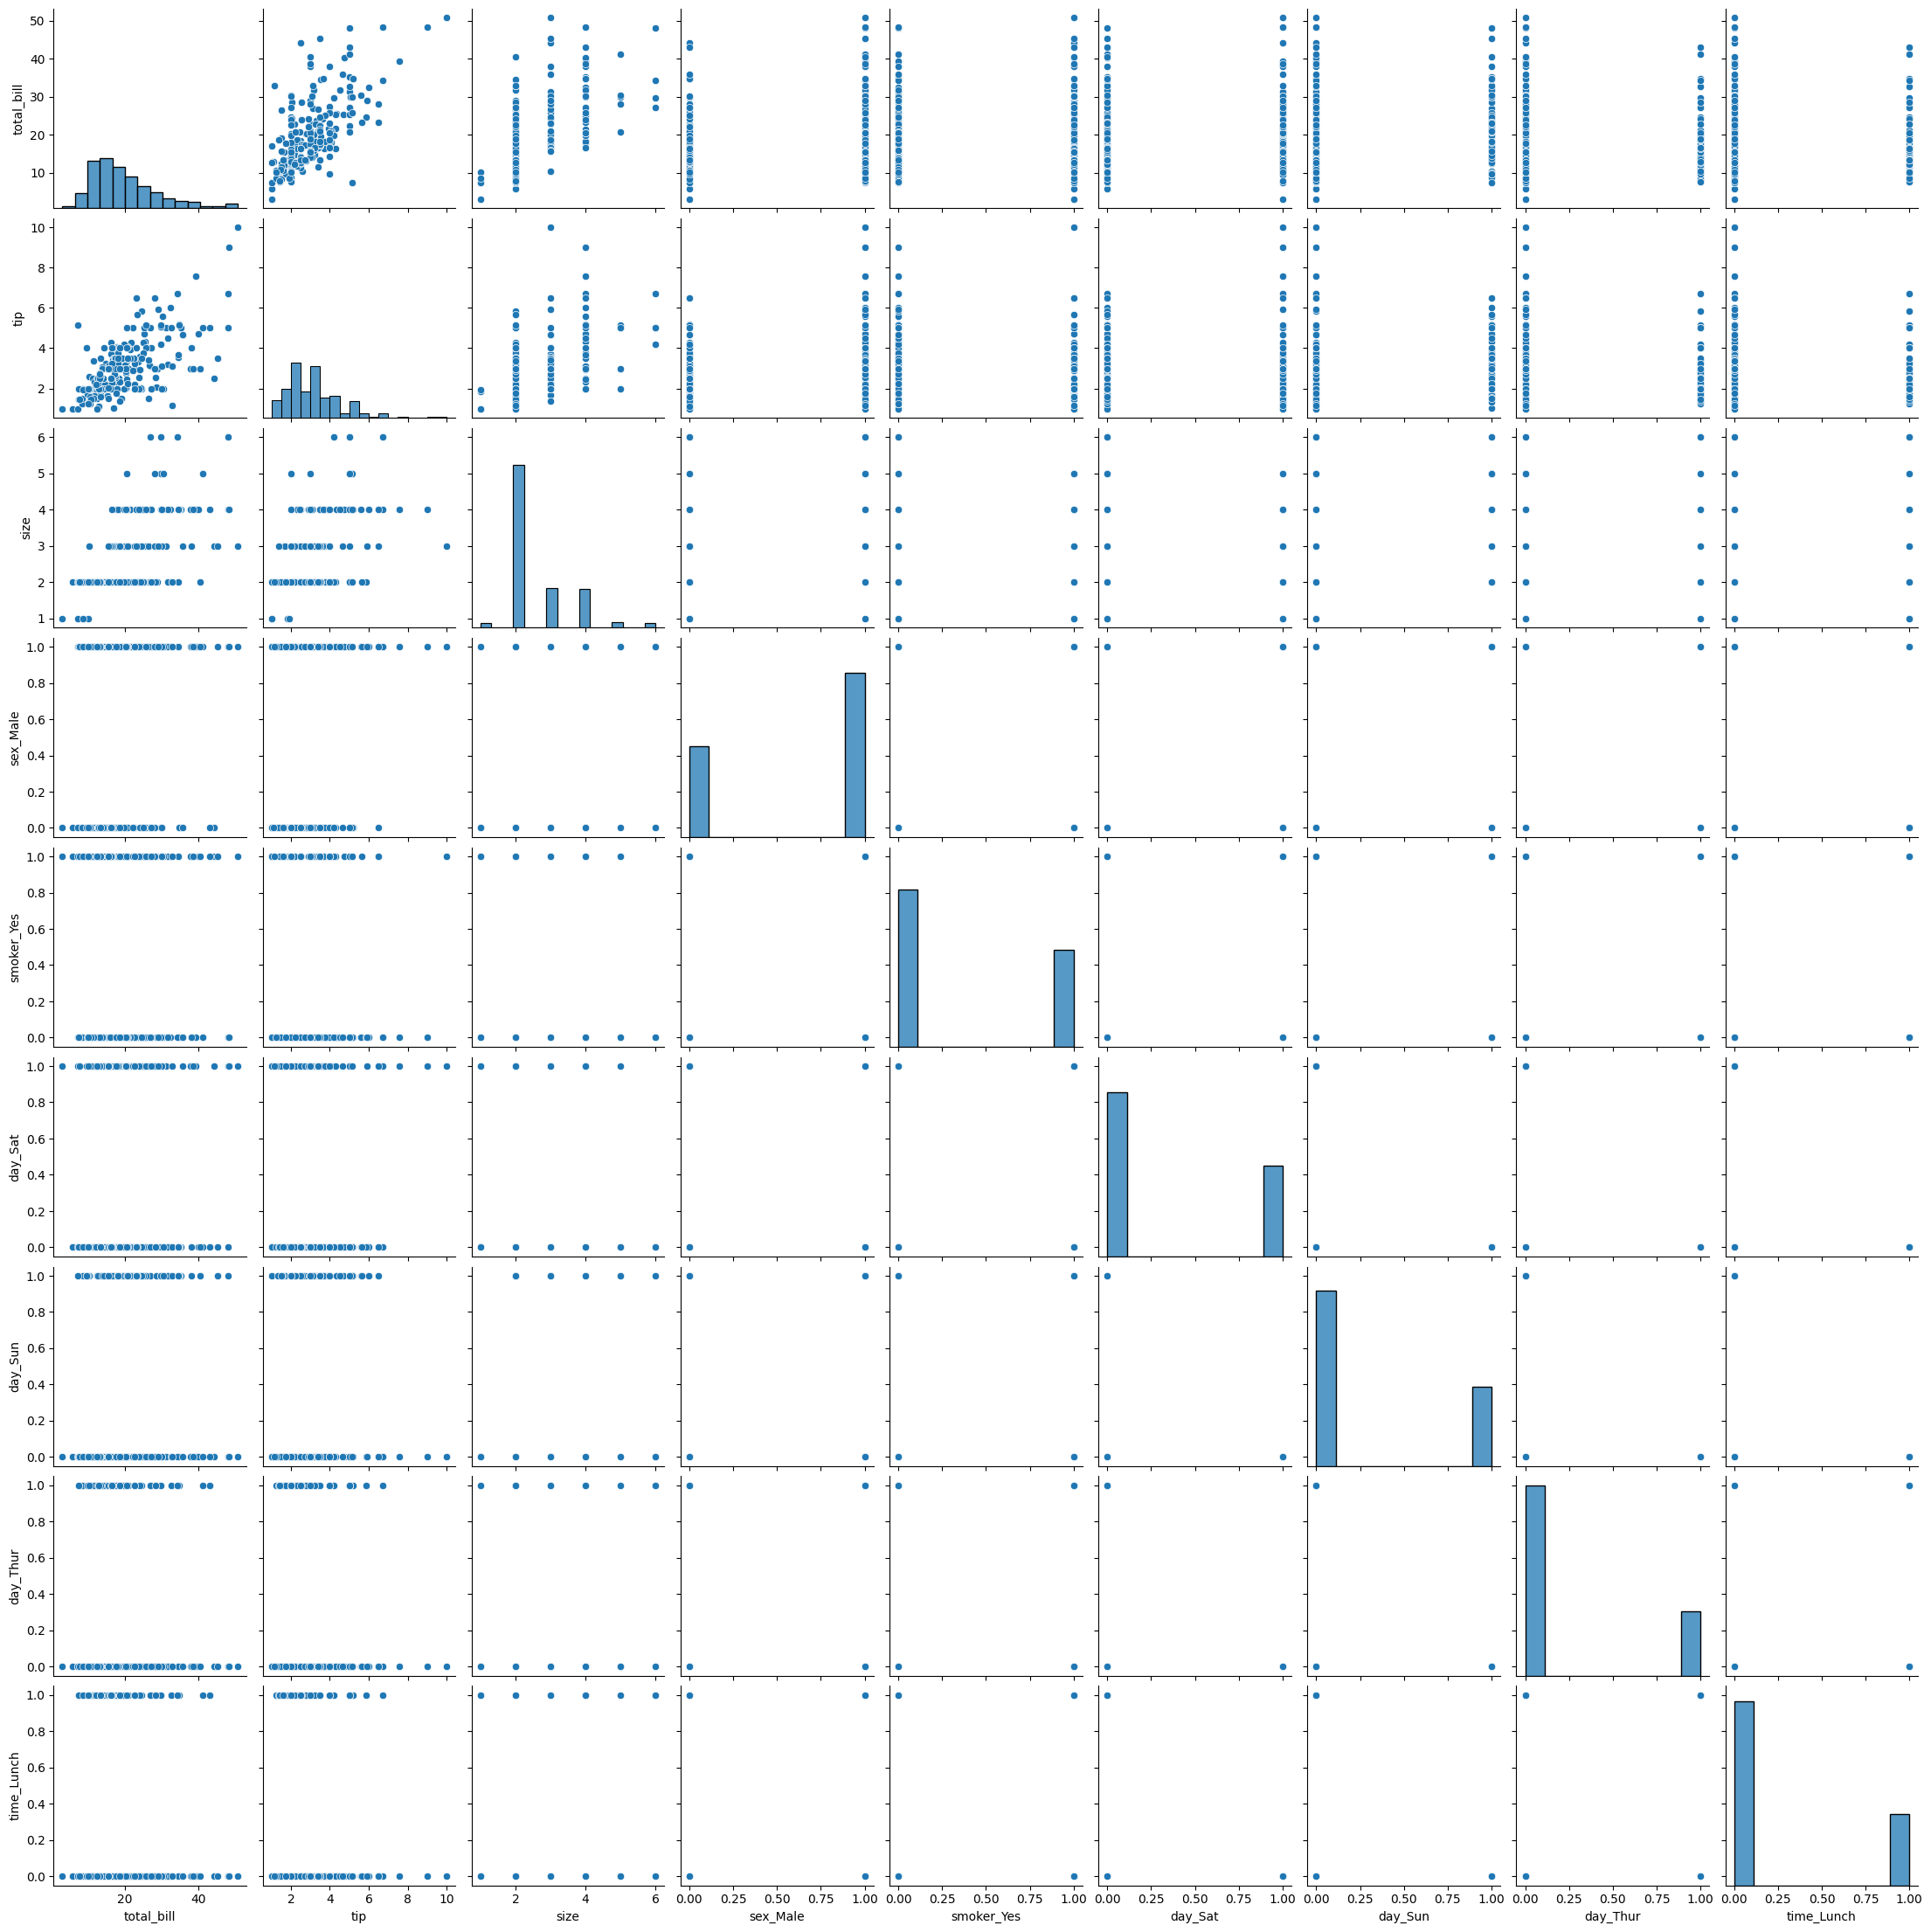

In [19]:
sns.pairplot(df2)
plt.show()

(c) Correlation Matrix (Heatmap)

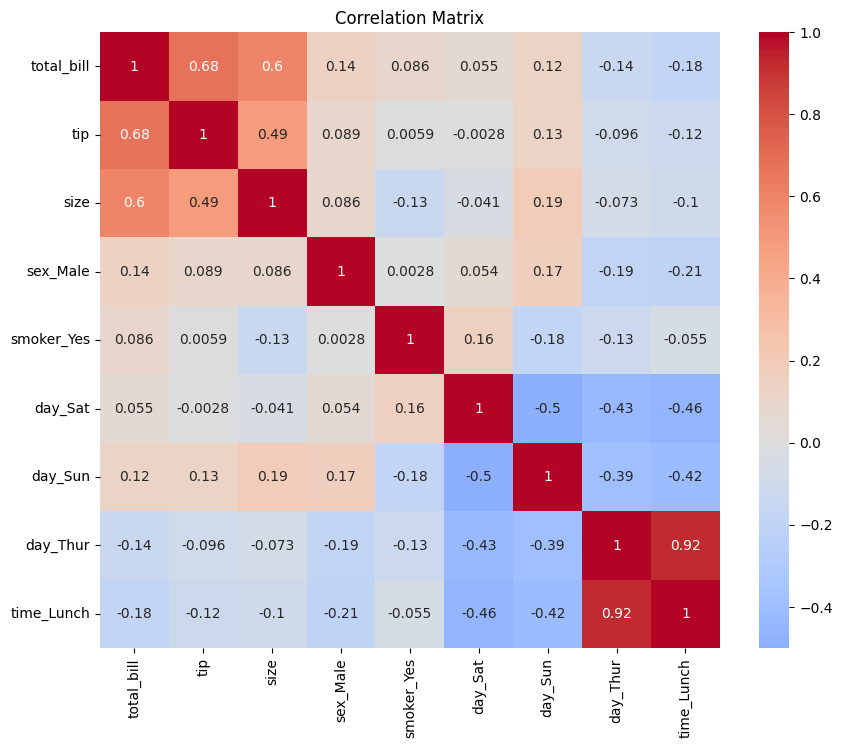

In [21]:
corr_matrix = df2.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

(d) Rainbow Test (for Linearity)

In [5]:
# Step 1: Convert all columns to numeric, force any non-numeric to NaN, and drop them
X_train1 = X_train.apply(pd.to_numeric, errors='coerce')
y_train1 = pd.to_numeric(y_train, errors='coerce')

# Step 2: Drop rows with any NaN values from X_train or y_train
X_train1 = X_train1.dropna()
y_train1 = y_train1[X_train1.index]  # Align y_train to X_train after dropping

# Step 3: Confirm all columns are numeric
print("Data types of X_train columns after conversion:")
print(X_train1.dtypes)

# Step 4: Convert X_train and y_train to numpy arrays of type float
X_train_numeric = X_train1.to_numpy().astype(float)
y_train_numeric = y_train1.to_numpy().astype(float)

# Step 5: Add a constant column for statsmodels
X_const = sm.add_constant(X_train_numeric)

# Step 6: Attempt to fit the model again
try:
    model = sm.OLS(y_train_numeric, X_const).fit()
    rainbow_stat, rainbow_p_value = linear_rainbow(model)
    print()
    print('Rainbow test statistic:', rainbow_stat)
    print('Rainbow test p-value:', rainbow_p_value)
except ValueError as e:
    print(f"Error after ensuring numeric types: {e}")

Data types of X_train columns after conversion:
total_bill    float64
size            int64
sex_Male         bool
smoker_Yes       bool
day_Sat          bool
day_Sun          bool
day_Thur         bool
time_Lunch       bool
dtype: object

Rainbow test statistic: 1.5493994941797338
Rainbow test p-value: 0.018647408553123045


(e) Residual Plot for Linear Regression

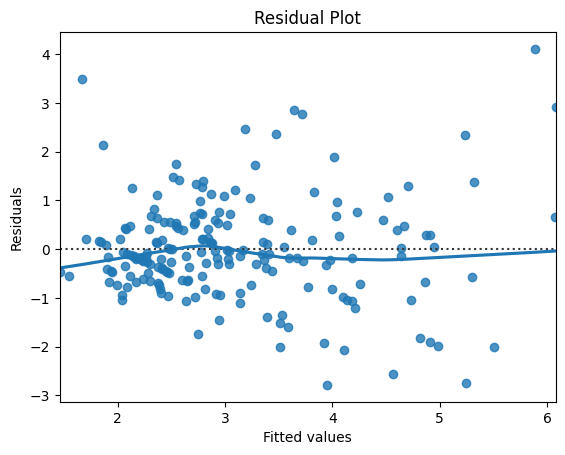

In [6]:
y_pred = model.predict(X_const)
residuals = y_train - y_pred
plt.figure()
sns.residplot(x=y_pred, y=residuals, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

(f) Line Plot (for Time-Series Data, if applicable)

<Figure size 1000x600 with 0 Axes>

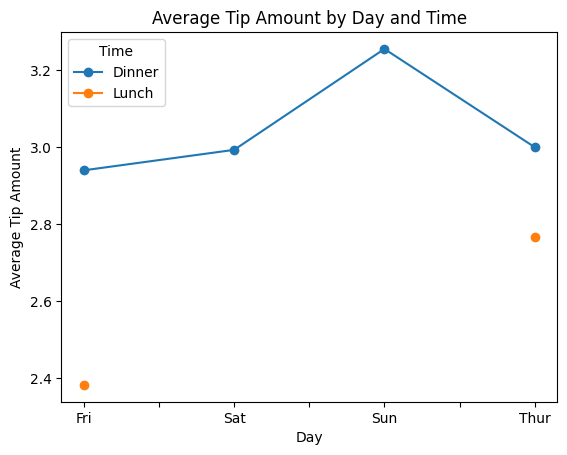

In [11]:
# Step 1: Aggregate the tip data based on day and time
# Calculate average tip amount per day and time for better trend visualization
data_grouped = df.groupby(['day', 'time'])['tip'].mean().unstack()

# Step 2: Plot the aggregated data
plt.figure(figsize=(10, 6))
data_grouped.plot(kind='line', marker='o')
plt.title('Average Tip Amount by Day and Time')
plt.xlabel('Day')
plt.ylabel('Average Tip Amount')
plt.legend(title='Time')
plt.show()

#6. Feature Importance (for Tree-Based Models)

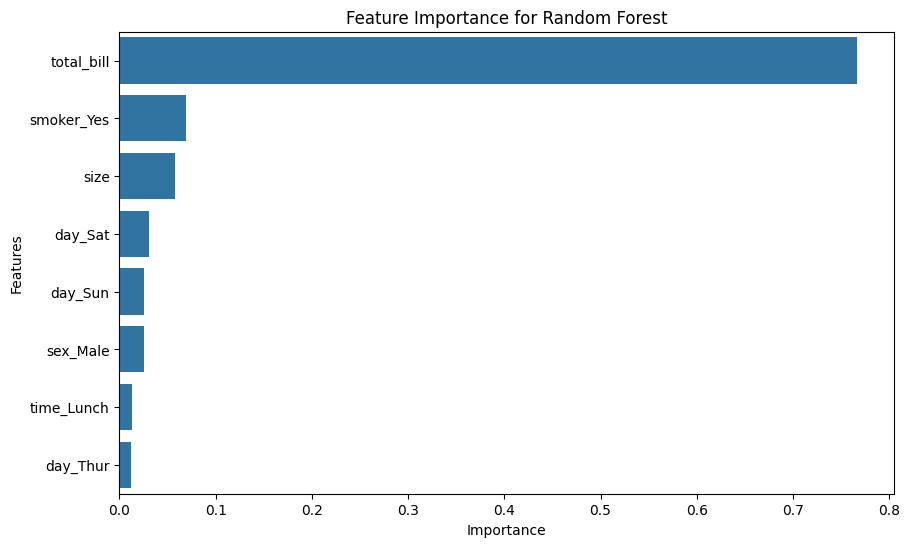

In [20]:
# Feature Importance for Random Forest
importances = forest.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance for Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# 7. Model Training and Evaluation

**Mean Absolute Error (MAE)**: Average of absolute errors between predicted and actual values.It gives an idea of how far the predictions are from actual values on average. Lower MAE means that, on average, the model's predictions are closer to the actual values.

---


**Mean Squared Error (MSE)**: Average of squared errors between predicted and actual values. Squaring the errors amplifies larger deviations, making MSE more sensitive to significant errors. Lower MSE indicates that the model not only has fewer errors overall but also avoids large errors more effectively.

---


**R-Squared**: R², or the coefficient of determination, represents the proportion of variance in the target variable that the model explains. It ranges from 0 to 1, where 1 indicates a perfect fit. A higher R² means the model explains more of the variability in the target data, which generally indicates a better fit.

In [22]:
# Define the row and column labels
metrics = ['MAE', 'MSE', 'R^2']
models = ['Linear', 'Ridge', 'Lasso', 'Decision Tree', 'Random Forest', 'Support Vector', 'K-Nearest Neighbors']

# Initialize a DataFrame with NaN values
df3 = pd.DataFrame(index=metrics, columns=models)

# Dictionary of models
model_dict = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Train, predict, and store metrics for each model
for model_name, model in model_dict.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the metrics in the DataFrame
    df3.loc['MAE', model_name] = mae
    df3.loc['MSE', model_name] = mse
    df3.loc['R^2', model_name] = r2

# Display the DataFrame with the results
print(df3)

       Linear     Ridge     Lasso Decision Tree Random Forest Support Vector  \
MAE  0.667133  0.666538   0.62561      0.770408      0.732543       0.567986   
MSE  0.703357  0.700748  0.566598      1.059345      0.844001       0.532376   
R^2  0.437302  0.439389  0.546712      0.152505      0.324784       0.574089   

    K-Nearest Neighbors  
MAE            0.718857  
MSE            0.876373  
R^2            0.298886  


Visualising the performance of the Models

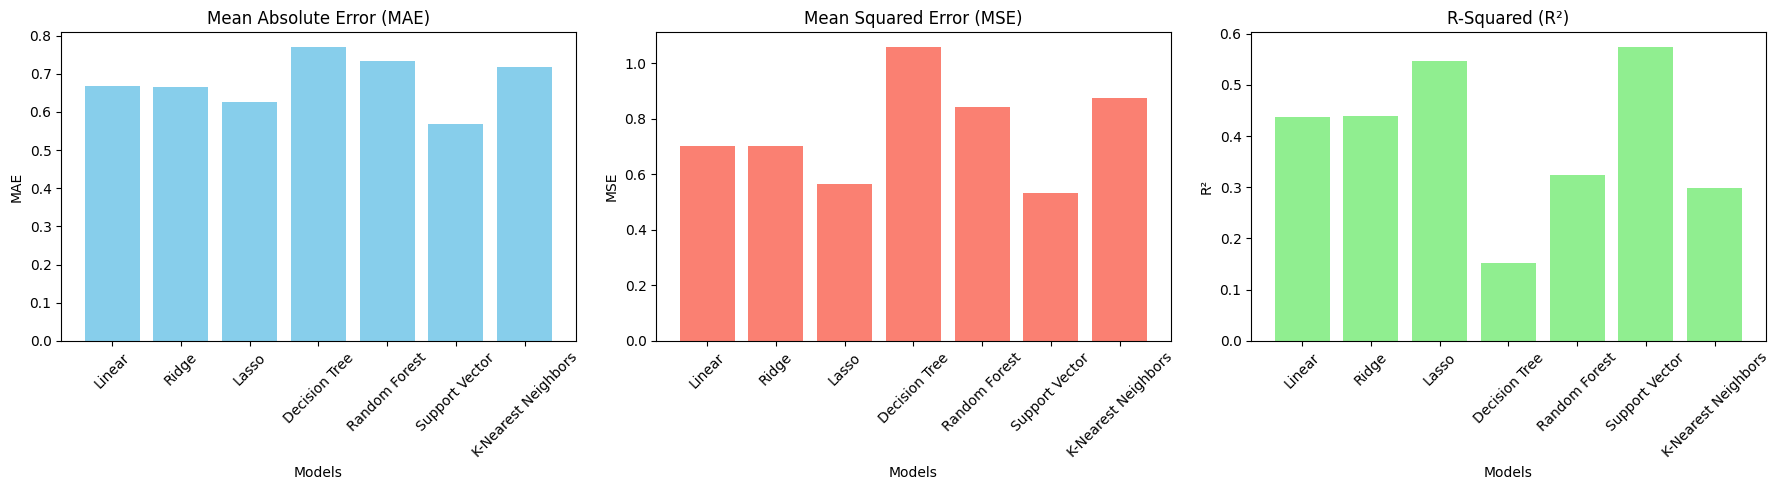

In [30]:
# Set up the plotting area with subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot MAE for each model
axes[0].bar(df3.columns, df3.loc['MAE'], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MAE')
axes[0].set_xticklabels(df3.columns, rotation=45)

# Plot MSE for each model
axes[1].bar(df3.columns, df3.loc['MSE'], color='salmon')
axes[1].set_title('Mean Squared Error (MSE)')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE')
axes[1].set_xticklabels(df3.columns, rotation=45)

# Plot R^2 for each model
axes[2].bar(df3.columns, df3.loc['R^2'], color='lightgreen')
axes[2].set_title('R-Squared (R²)')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('R²')
axes[2].set_xticklabels(df3.columns, rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Suppress warnings
warnings.filterwarnings("ignore")

#Key Insights and Actionable Recommendations

1. **Analyze Tip Trends by Day and Time**
As Average Tip amount is highest during dinners on Sundays, it is recommended to
allocate more staff on Sundays to improve service quality, which could encourage even higher tips. **Targeted Promotions**: Introduce special promotions during Lunches on Friday & Sunday to potentially increase tips and total sales.
2. **Group Incentives**: Encourage larger groups with group discounts or special table packages since they may be more likely to leave higher cumulative tips. **Tailored Service**: Train staff to understand and cater to the preferences of different customer demographics, potentially increasing tips and customer satisfaction.
3. **Suggestive Upselling**: Encourage waitstaff to suggest add-ons or premium menu items to increase bill totals without being too pushy, as higher bills could lead to higher absolute tip amounts. **Introduce Tip-Splitting for Large Bills**: If bill amounts become quite large, customers might tip a lower percentage. Providing a recommended tip range (e.g., 15%, 20%) for large bills may nudge customers toward a higher tip.
4. **Customer Feedback Collection**: Consider collecting feedback, especially during low-tip times, to identify and address any specific service issues.
5. **Digital Tipping Option**: If customers are increasingly paying with cards or digital payments, offering a digital tipping option can facilitate tipping, especially for customers who may not have cash on handc by implementing digital tipping options on payment systems, allowing customers to easily add a tip after seeing their bill.
6. **Seasonal Promotions**: For high tipping seasons or local events, consider special promotions or services to boost both the volume of customers and potential tips. **Special Staffing During Busy Times**: For peak seasons or events, ensure that staff is adequately prepared to handle increased demand without sacrificing service quality, helping maximize tips and customer satisfaction.
7. **Tip Incentives for Waitstaff Insight**: Encouraging waitstaff to go above and beyond with service can improve customer experience and, consequently, tip amounts. **Recognition Program**: Consider implementing a recognition program for staff members who receive higher-than-average tips, which can motivate them to provide excellent service consistently.

By focusing on these insights and applying the recommendations, management can enhance customer service strategies, which may lead to an increase in both tip amounts and overall customer satisfaction, ultimately benefiting revenue and customer loyalty.